# Tofts model

In [1]:
# import statements
import os
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Background
[to do add some background info here]

## Test data
The QIBA DRO data was used for testing of the Tofts model.

Version: QIBA_v11_Tofts from MR Modality Datasets/Dynamic Contrast Enhanced (DCE) MRI/DCE-MRI DRO Data and Code/DCE-MRI DRO Data (Daniel Barboriak) /QIBA_v11_Tofts/QIBA_v11_Tofts_GE/T1_tissue_500/DICOM_dyn

Test case labels: test_vox_T{parameter combination}_{SNR}, e.g. test_vox_T5_30

To get the high SNR dataset, data was averaged as follows:
- datVIF = data[:, :9, :]
- datVIF = np.mean(datVIF, axis=(0, 1))
- datT1 = np.mean(data[44:49, 13:18, :], (0, 1))
- datT2 = np.mean(data[32:37, 21:26, :], (0, 1))
- datT3 = np.mean(data[42:47, 23:28, :], (0, 1))
- datT4 = np.mean(data[22:27, 32:37, :], (0, 1))
- datT5 = np.mean(data[22:27, 43:48, :], (0, 1))

Noise was added to the high-SNR data to obtain data at different SNRs

The DRO data are signal values, which were converted to concentration curves using dce_to_r1eff from https://github.com/welcheb/pydcemri/blob/master from David S. Smith

Input values and reference values were found from the accompanying pdf document, which describes the values per voxel. 
- T1 blood of 1440
- T1 tissue of 500
- TR=5 ms
- FA=30
- Hct=0.45


Tolerances
- $v_e$: a_tol=0.05, r_tol=0, start=0.2, bounds=(0,1)
- $K^{trans}$: a_tol=0.005, r_tol=0.01, start=0.6, bounds=(0,5), units [/min]
- delay: a_tol=0.2, r_tol=0, start=0, bounds=(-10,10), units [s]

source: https://qibawiki.rsna.org/images/1/14/QIBA_DRO_2015_v1.42.pdf and https://qidw.rsna.org/#collection/594810551cac0a4ec8ffe574/folder/5e20ccb8b3467a6a9210e9ff

### Visualize test data
showing the data from high SNR from the original DRO and lowest SNR of 20

<Figure size 432x288 with 0 Axes>

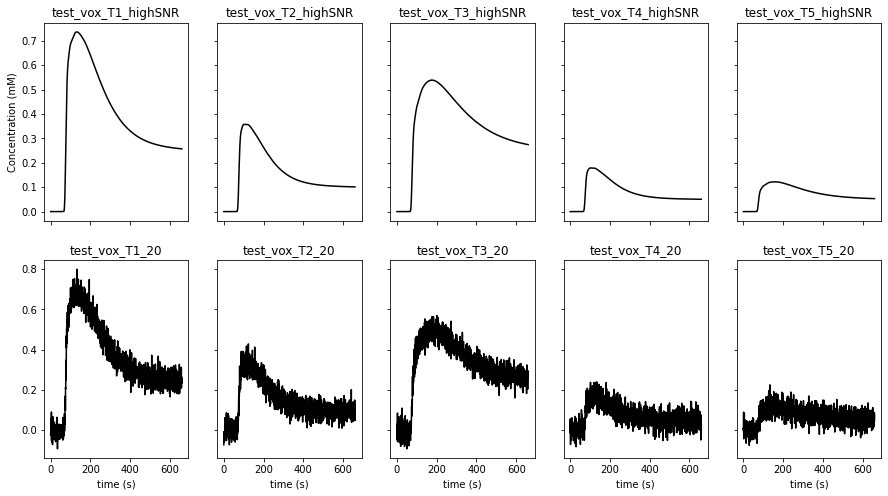

In [2]:
#plot test data
filename = ('../test/DCEmodels/data/dce_DRO_data_tofts.csv')
# read from CSV to pandas
df1 = pd.read_csv(filename)
#print(df1)

plt.figure()
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(15,8))
for currentvoxel in range(5):
    labelname = 'test_vox_T' + str(currentvoxel+1) + '_highSNR'
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax[0,currentvoxel].plot(t, c, color='black', label='highSNR')
    ax[0,currentvoxel].set_title(labelname)
    if currentvoxel ==0:
        ax[0,currentvoxel].set_ylabel('Concentration (mM)')
    
    
    labelname = 'test_vox_T' + str(currentvoxel+1) + '_20'
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax[1,currentvoxel].set_title(labelname)
    ax[1,currentvoxel].plot(t, c, color='black', label='SNR 20')
    ax[1,currentvoxel].set_xlabel('time (s)')
   
    

## Import data

A JSON named `results-meta.json` is created to isolate the meta information. The following script can read this JSON and construct the corresponding data frame. The JSON contains a list of entries. Each entry contains the `path`, `filename`, `category`, `method` and `author`. To incorporate future results, one can just update this JSON file and re-run the following scripts.


In [3]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [4]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'DCEmodels') & (entry['method'] == 'tofts') :
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [5]:
# label data source
df['source']=''
df.loc[df['label'].str.contains('highSNR'),'source']='highSNR'
df.loc[df['label'].str.contains('_20'),'source']='SNR20'
df.loc[df['label'].str.contains('_30'),'source']='SNR30' 
df.loc[df['label'].str.contains('_50'),'source']='SNR50' 
df.loc[df['label'].str.contains('_100'),'source']='SNR100' 

author_list = df.author.unique()
no_authors = len(author_list)

# calculate error between measured and reference values
df['error_Ktrans'] = df['Ktrans_meas'] - df['Ktrans_ref']
df['error_ve'] = df['ve_meas']- df['ve_ref']

# tolerances
tolerances = { 'Ktrans': {'atol' : 0.005, 'rtol': 0.01 },'ve': {'atol':0.05, 'rtol':0}}

## Results

The data of all test voxels are combined (low and high SNR)

<Figure size 432x288 with 0 Axes>

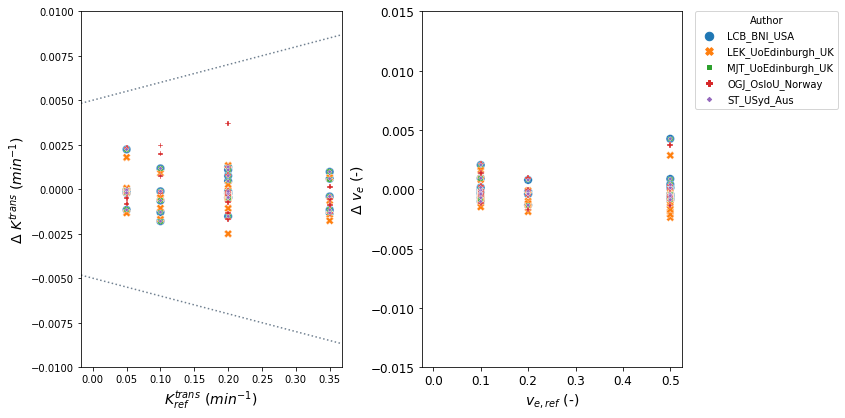

In [6]:
plt.figure()
fig, ax = plt.subplots(1,2, sharey='none', figsize=(10,6))
plot_bland_altman(ax[0], df, tolerances, 'Ktrans', ylim=(-0.01,0.01),label_xaxis='$K^{trans}_{ref}$ ($min^{-1}$)',label_yaxis='$\Delta$ $K^{trans}$ ($min^{-1}$)')

plot_bland_altman(ax[1], df, tolerances, 've', ylim=(-0.015,0.015),label_xaxis='$v_{e,ref}$ (-)',label_yaxis='$\Delta$ $v_{e}$ (-)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='Author', loc='upper left', borderaxespad=0)


Bias results estimated $K^{trans}$ values combined for all voxels

In [7]:
resultsBA = bland_altman_statistics(data=df,par='error_Ktrans',grouptag='author')
print(resultsBA)

                        bias  std_error  LoA lower  LoA upper
author                                                       
LCB_BNI_USA        -0.000112   0.000994  -0.002061   0.001837
LEK_UoEdinburgh_UK -0.000483   0.000984  -0.002411   0.001445
MJT_UoEdinburgh_UK -0.000114   0.000993  -0.002060   0.001833
OGJ_OsloU_Norway    0.000145   0.001305  -0.002412   0.002702
ST_USyd_Aus        -0.000110   0.000994  -0.002059   0.001839


In [8]:
# split in SNR level
subset = df[(df['source']=='highSNR')]
resultsBA = bland_altman_statistics(data=subset,par='error_Ktrans',grouptag='author')
print('Bias results estimated Ktrans values for high SNR voxels')
print(resultsBA)

subset = df[(df['source']=='SNR20')]
resultsBA = bland_altman_statistics(data=subset,par='error_Ktrans',grouptag='author')
print('Bias results estimated Ktrans values for low SNR voxels (SNR = 20)')
print(resultsBA)

Bias results estimated Ktrans values for high SNR voxels
                        bias  std_error  LoA lower  LoA upper
author                                                       
LCB_BNI_USA        -0.000215   0.000134  -0.000478   0.000049
LEK_UoEdinburgh_UK -0.000751   0.000467  -0.001667   0.000165
MJT_UoEdinburgh_UK -0.000215   0.000134  -0.000478   0.000049
OGJ_OsloU_Norway   -0.000218   0.000135  -0.000481   0.000046
ST_USyd_Aus        -0.000213   0.000133  -0.000474   0.000049
Bias results estimated Ktrans values for low SNR voxels (SNR = 20)
                        bias  std_error  LoA lower  LoA upper
author                                                       
LCB_BNI_USA         0.000357   0.001558  -0.002697   0.003412
LEK_UoEdinburgh_UK -0.000386   0.001243  -0.002822   0.002050
MJT_UoEdinburgh_UK  0.000343   0.001559  -0.002713   0.003398
OGJ_OsloU_Norway    0.001088   0.002278  -0.003378   0.005553
ST_USyd_Aus         0.000359   0.001558  -0.002696   0.003414


Bias results estimated $v_e$ values combined for all voxels

In [9]:
resultsBA = bland_altman_statistics(data=df,par='error_ve',grouptag='author')
print(resultsBA)

                        bias  std_error  LoA lower  LoA upper
author                                                       
LCB_BNI_USA         0.000052   0.001132  -0.002166   0.002270
LEK_UoEdinburgh_UK -0.000767   0.001151  -0.003023   0.001489
MJT_UoEdinburgh_UK  0.000052   0.001130  -0.002164   0.002267
OGJ_OsloU_Norway   -0.000014   0.001126  -0.002221   0.002193
ST_USyd_Aus         0.000052   0.001132  -0.002166   0.002271


## Notes
Additional notes/remarks

### References